In [1]:
%load_ext watermark
%watermark

Last updated: 2022-12-01T23:30:11.220560-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.6.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import spacy

import pandas as pd

import numpy as np

import seaborn as sns

import pickle

import unidecode

import re

import os

from datetime import datetime

import matplotlib.pyplot as plt

from wordcloud import WordCloud

from string import punctuation

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from ipywidgets import interact

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.python.platform import build_info as build
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Flatten, Input
from keras.preprocessing.text import Tokenizer
from keras.constraints import maxnorm
from keras.callbacks import TensorBoard

import nltk  # Natural language toolkit
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')  # stopwords
stopwords = stopwords.words('spanish')

# nlp = spacy.load('es_core_news_lg')  # large
nlp = spacy.load('es_core_news_sm')  # small
# nlp = spacy.load('en_core_web_lg') # large
# nlp = spacy.load('en_core_web_sm')  # small

sns.set(font_scale=0.7)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ereye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Resume

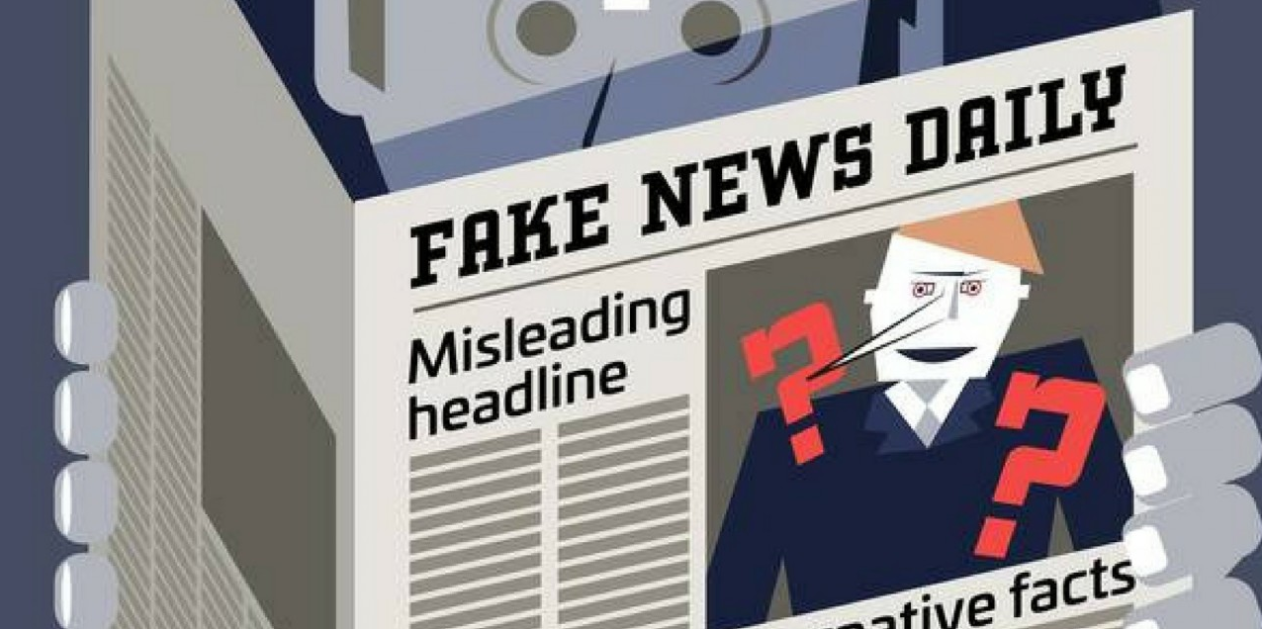


# Data Collection

In [3]:
df = pd.read_csv('_resources/noticias.csv')

# Rename the columns
#

df.head()

,descripcion,categoria
0,"Aunque parezca mentira, las emisiones de dióxi...",cultura
1,Hubo un proyecto impulsado por la Unión Europe...,cultura
2,China ha confirmado la conclusión con éxito de...,tecnología
3,"En su fructífera carrera como humorista, actor...",cultura
4,Tras dos años de negociación entre la instituc...,cultura


# Data Wrangling

In [4]:
target_names = df.categoria.unique()
target_names

array(['cultura', 'tecnología', 'ocio'], dtype=object)

Verificar los tipos de datos.

In [5]:
df.dtypes

descripcion    object
categoria      object
dtype: object

In [6]:
df = df.astype({'categoria': 'category'})
df.dtypes

descripcion      object
categoria      category
dtype: object

Combinar los diferentes dataset cargados.

In [7]:
#

Columna objetivo y columna independiente.

In [8]:
target_column, feature_column = 'categoria', 'descripcion'

# Data Visualization

## Summarize Data Lenght


Media de palabras: 340.34
Desviación estandard: 155.02


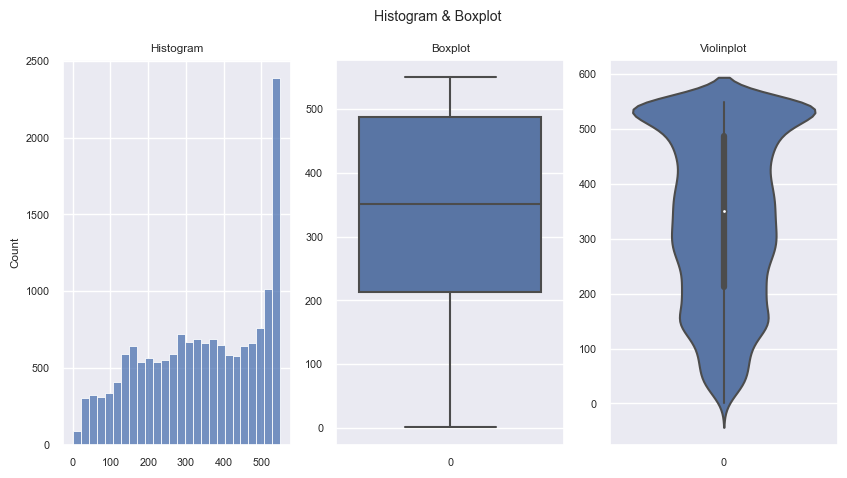

In [9]:
def summarize_data_lenght(data):
    cc = [len(x) for x in data]

    print(f'\nMedia de palabras: {round(np.mean(cc), 2)}')
    print(f'Desviación estandard: {round(np.std(cc), 2)}')

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    fig.suptitle('Histogram & Boxplot')

    sns.histplot(data=cc, ax=axes[0])
    axes[0].set_title('Histogram')

    sns.boxplot(data=cc, ax=axes[1])
    axes[1].set_title('Boxplot')

    sns.violinplot(data=cc, ax=axes[2])
    axes[2].set_title('Violinplot')


summarize_data_lenght(data=df[feature_column])

## Frequency Distribution

In [10]:
sentences = [doc.split() for doc in df[feature_column]]
tokenized_word = np.concatenate(sentences).tolist()

filtered_review = []
for word in tokenized_word:
    # Elimina las tildes y las ñ
    word = unidecode.unidecode(word)

    # Elimina los caracteres especiales
    word = re.sub(r'[^a-z0-9]', '', word.lower()).strip()

    # Stop Words Removal
    if word not in stopwords:
        filtered_review.append(word)

filtered_review = filter(lambda val: val != '', filtered_review)
filtered_review = list(filtered_review)
filtered_review[:20]

['aunque',
 'parezca',
 'mentira',
 'emisiones',
 'dioxido',
 'carbono',
 'co2',
 'nitrogeno',
 'atmosfericos',
 'actuado',
 'fertilizante',
 'hecho',
 'tierra',
 'hoy',
 'mas',
 'verde',
 'hace',
 '30',
 'anos',
 'acabando']

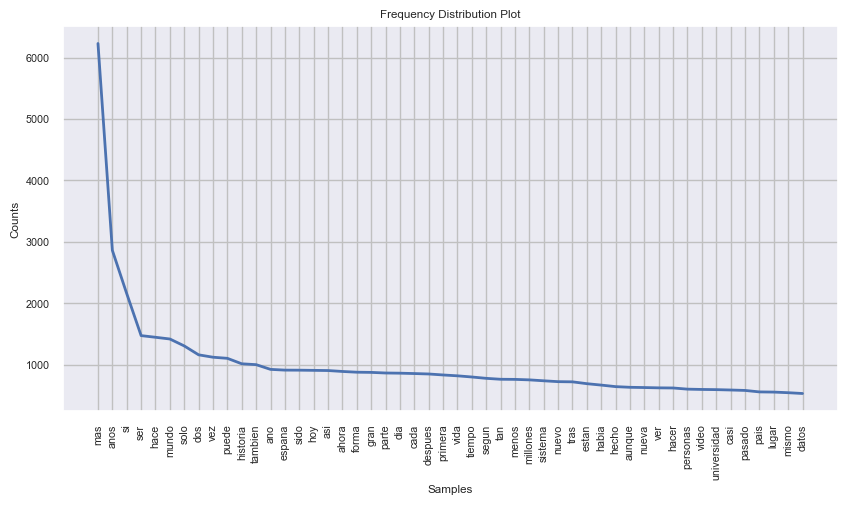

In [11]:
plt.figure(figsize=(10, 5))

fdist = FreqDist(filtered_review)
fdist.plot(50, cumulative=False, title='Frequency Distribution Plot')

plt.show()

## Word Cloud

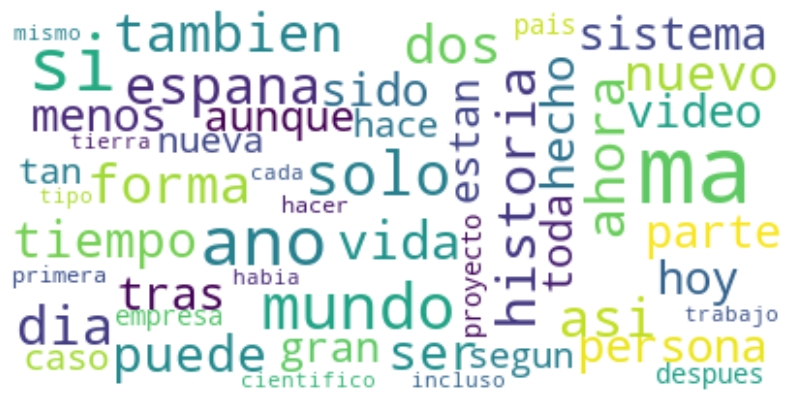

In [12]:
plt.figure(figsize=(10, 10))

wordcloud = WordCloud(max_font_size=50, max_words=50,
                      background_color="white").generate(' '.join(filtered_review))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data Cleaning

In [13]:
df.head()

,descripcion,categoria
0,"Aunque parezca mentira, las emisiones de dióxi...",cultura
1,Hubo un proyecto impulsado por la Unión Europe...,cultura
2,China ha confirmado la conclusión con éxito de...,tecnología
3,"En su fructífera carrera como humorista, actor...",cultura
4,Tras dos años de negociación entre la instituc...,cultura


In [14]:
# Completely empty rows are removed.
# In case you want to delete the row if any of its values is missing, use 'any' in the 'how' parameter
# Use subset['col1', 'col2'] if you want to apply to some columns only.
df.dropna(axis=0, how='all', inplace=True)

df.drop_duplicates(keep='first', inplace=True)

df.shape

(16367, 2)

# Machine Learning

In [15]:
df.reset_index(drop=True, inplace=True)

features = df[feature_column]
targets = df[target_column]

## Standardization

In [16]:
class MyStandardizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cache):
        self.cache = cache

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.Series) and self.cache is not None:
            return self.cache[X.index]

        array = X.values if isinstance(X, pd.Series) else X

        corpus = []

        for i in range(0, len(array)):
            doc = nlp(array[i])

            # lemmatizer and lower and strip and is_alpha and no is_stop (spacy)
            tokens = [tok.lemma_.lower().strip()
                      for tok in doc if tok.is_alpha == True and tok.is_stop == False]

            # Seleccionar solo letras
            tokens = [re.sub('[^a-zá-ú]', '', tok) for tok in tokens]

            # stopwords and punctuation (nltk)
            tokens = [
                tok for tok in tokens if tok not in stopwords and tok not in punctuation]

            tokens = ' '.join(tokens)

            corpus.append(tokens)

            print("\rTransforming data: {0} of {1}".format(
                i+1, len(array)), end='')

        return np.array(corpus)

Se cargan los datos ya limpios (si existen), caso contrario ejecutar el algoritmo anterior.

array(['parecer mentira emisión dióxido carbono nitrógeno atmosférico actuar fertilizante tierra verde año acabar ecosistema terrestre saturar encaminar época calentamiento principal conclusión estudio internacional publicado nature ecology evolution trabajo avisar tierra pasar época fertilización calentamiento',
       'proyecto impulsado unión europea universidad llegar terminar manual método enseñanza simultáneo lengua románico permitir aprender lengua convertirtar conocedor pasivo hablarlar entenderla filólogo español ángel lópez abogar introducir método sistema educativo asignatura lengua servir español poder entender lengua euskera',
       'china confirmar conclusión éxito operación implante dental realizado forma totalmente autónomo robot logro intervención personal humano'],
      dtype='<U454')


Media de palabras: 201.03
Desviación estandard: 91.25


None

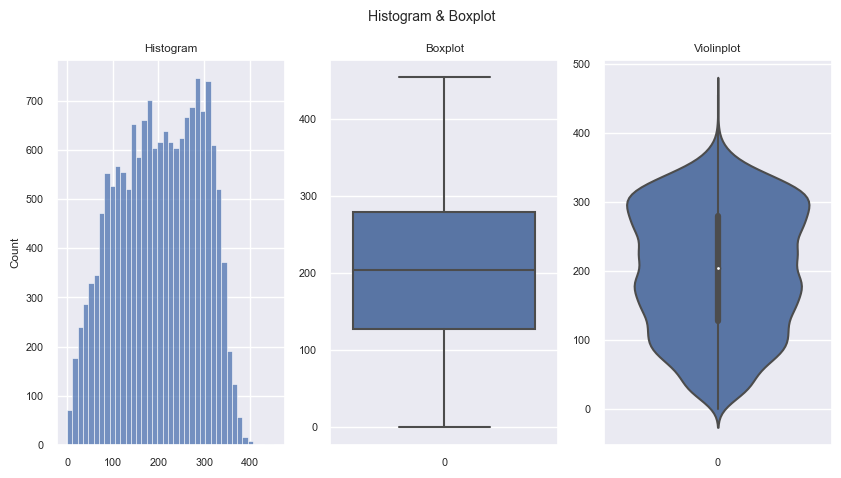

In [17]:
try:
    pkl_filename = '_resources/standardized_data_0501.pkl'

    standardized_data = pickle.load(open(pkl_filename, 'rb'))
except:
    standardization = MyStandardizationTransformer(cache=None)
    standardized_data = standardization.fit_transform(features)
    del standardization

    pickle.dump(standardized_data, open(pkl_filename, 'wb'))
finally:
    display(standardized_data[:3])
    display(summarize_data_lenght(data=standardized_data))

Se eliminan los elementos vacíos.

In [18]:
# empty_indexs = [i for i, text in enumerate(corpus) if text == '']
# print(empty_indexs)

# corpus = np.delete(corpus, empty_indexs)

# df.drop(index=empty_indexs, inplace=True)
# df.reset_index(drop=True, inplace=True)

# features = df[feature_column]
# targets = df[target_column]

# len(corpus), len(df)

## Vectorizer

In [19]:
# TfidfVectorizer acepta parámetros para realizar la limpieza de los datos realizada manualmente en la sesión anterior.
# La limpieza manual es mejor porque se puede limpiar otros detalles más adelante.
# Máxima cantidad de columnas. Se seleccionarán las palabras que más frecuencias tengan.
# Por ejemplo, si aparece un nombre o apellido es probable que solo tenga una frecuencia, esa columna no es relevante.
# Palabras con más importancia (probar varias opciones)
vectorizer = TfidfVectorizer()   # TfidfVectorizer, CountVectorizer

vector = vectorizer.fit_transform(standardized_data[:20000])
vector.shape

(16367, 44255)

Vocabulary.

In [20]:
vocabulary = vectorizer.vocabulary_
display(list(vocabulary.items())[:10])
del vocabulary

[('parecer', 30630),
 ('mentira', 26681),
 ('emisión', 14151),
 ('dióxido', 13040),
 ('carbono', 6768),
 ('nitrógeno', 28929),
 ('atmosférico', 3565),
 ('actuar', 537),
 ('fertilizante', 16988),
 ('tierra', 40408)]

Vectors.

In [21]:
display(vector.shape)
display(vector)

(16367, 44255)

<16367x44255 sparse matrix of type '<class 'numpy.float64'>'
	with 378837 stored elements in Compressed Sparse Row format>

Se obtienen los vectores.

In [22]:
print(standardized_data[0])
vectorizer_df = pd.DataFrame(data=vectorizer.transform([standardized_data[0]]).toarray(),
                             columns=vectorizer.get_feature_names_out())

# Se Seleccionan solamente las columnas (palabras) del texto, caso contrario se observarían muchos 0s.
display(vectorizer_df[standardized_data[0].split()])

del vectorizer_df

parecer mentira emisión dióxido carbono nitrógeno atmosférico actuar fertilizante tierra verde año acabar ecosistema terrestre saturar encaminar época calentamiento principal conclusión estudio internacional publicado nature ecology evolution trabajo avisar tierra pasar época fertilización calentamiento


,parecer,mentira,emisión,dióxido,carbono,nitrógeno,atmosférico,actuar,fertilizante,tierra,...,nature,ecology,evolution,trabajo,avisar,tierra,pasar,época,fertilización,calentamiento
0,0.115887,0.168554,0.145581,0.180213,0.158521,0.183684,0.181315,0.164905,0.220573,0.214263,...,0.159848,0.236983,0.220573,0.106742,0.163803,0.214263,0.0993,0.23735,0.227384,0.358322


Compute the cosine similarity matrix. `linear_kernel` is the same as `cosine_similarity`.

In [23]:
cosine_sim = cosine_similarity(vector, vector)
cosine_sim.shape

(16367, 16367)

In [24]:
cosine_sim[0:5]

array([[1.        , 0.        , 0.03997984, ..., 0.        , 0.00899071,
        0.09872343],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03997984, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04000232, 0.        , 0.02927736, ..., 0.01092779, 0.        ,
        0.        ],
       [0.00373343, 0.        , 0.        , ..., 0.        , 0.00839394,
        0.0119435 ]])

## Cross Validation

In [25]:
def show_confusion_matrix(estimator, X, y):
    titles_options = {"Confusion Matrix": None,
                      "Normalized Confusion Matrix": 'true'}

    f, axes = plt.subplots(1, len(titles_options),
                           figsize=(10, 5), sharey='row')

    for i, (title, normalize) in enumerate(titles_options.items()):
        disp = ConfusionMatrixDisplay.from_estimator(estimator, X, y, display_labels=target_names,
                                                     cmap=plt.cm.Blues, normalize=normalize, ax=axes[i])
        disp.ax_.set_title(title)

    plt.show()

In [26]:
# Al no existir una estimador parecido a TransformedTargetRegressor para Keras, implementamos el nuestro.
# Esperar actualizaciones...

class MyTransformedTargetClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, classifier, transformer):
        self.classifier = classifier
        self.transformer = transformer

    def fit(self, X, y, **kwargs):
        y = y.values

        y = self.__reshape_target(y)
        y = self.transformer.fit_transform(y)

        y = self.__squeeze_target(y)
        self.classifier.fit(X, y, **kwargs)

        return self

    def predict(self, X, **kwargs):
        y = self.classifier.predict(X, **kwargs)

        y = self.__reshape_target(y)
        y = self.transformer.inverse_transform(y)

        return y.squeeze()

    def __reshape_target(self, y):
        if isinstance(self.transformer, LabelEncoder) == False:
            y = y.reshape(-1, 1) if y.ndim == 1 else y

        return y

    def __squeeze_target(self, y):
        if isinstance(self.transformer, LabelEncoder) == False:
            y = y.squeeze()

        return y

    def transform_target(self, y):
        y = y.values
        y = self.__reshape_target(y)
        return self.transformer.transform(y)

    def save(self, path):
        if os.path.isdir(path) == False:
            os.mkdir(path)

        pickle.dump(self.classifier['standardization'],
                    open(f'{path}/standardization.pkl', 'wb'))

        pickle.dump(self.classifier['vectorizer'],
                    open(f'{path}/vectorizer.pkl', 'wb'))

        self.classifier['model'].save(f'{path}/model.h5')

        pickle.dump(self.transformer,
                    open(f'{path}/transformer.pkl', 'wb'))

    @staticmethod
    def load(path):
        standardization = pickle.load(
            open(f'{path}/standardization.pkl', 'rb'))

        vectorizer = pickle.load(open(f'{path}/vectorizer.pkl', 'rb'))

        model = load_model(f'{path}/model.h5')

        transformer = pickle.load(open(f'{path}/transformer.pkl', 'rb'))

        pipe = Pipeline(steps=[('standardization', standardization),
                               ('vectorizer', vectorizer),
                               ('model', model)])

        return MyTransformedTargetClassifier(classifier=pipe, transformer=transformer)

In [27]:
results = pd.DataFrame(
    columns=['NAME', 'TYPE', 'ACCURACY', 'ESTIMATOR'])


def my_grid_search_cv(model, X, y, vectorizer, results, param_grid):
    estimators = []

    steps = [('standardization', MyStandardizationTransformer(standardized_data)),
             ('vectorizer', vectorizer(analyzer='word', max_features=None)),
             ('model', model)]

    pipe = Pipeline(steps=steps)

    target_transformer = LabelEncoder()
#     target_transformer = OrdinalEncoder()
    estimator = MyTransformedTargetClassifier(classifier=pipe,
                                              transformer=target_transformer)

    # n_jobs=1 porque MyStandardizationTransformer usa nlp y solo acepta una instancia a la vez (no multihilo)
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,
                               scoring='accuracy', cv=2, n_jobs=1, return_train_score=True)
    grid_search.fit(X, y)
    estimator = grid_search.best_estimator_
    estimators.append(estimator)

    score = round(grid_search.best_score_, 4)

    print(
        f'The model {str(model)} has a degree of accuracy of {score * 100}%.')
    show_confusion_matrix(estimator.classifier, X,
                          estimator.transform_target(y))

    estimator.classifier['standardization'].set_params(**{'cache': None})
    display(estimator)

    new_df = pd.DataFrame(data={'NAME': [str(model)], 'TYPE': 'ML', 'ACCURACY': [score],
                                'ESTIMATOR': [estimator]})
    results = pd.concat([results, new_df], ignore_index=True)

    return (results,) + tuple(estimators)

## Logistic Regression

The model LogisticRegression(max_iter=300) has a degree of accuracy of 71.38%.


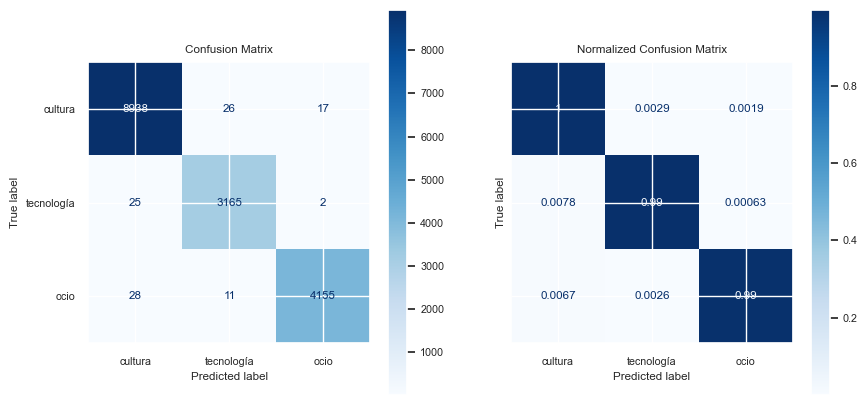

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('standardization',
                                                          MyStandardizationTransformer(cache=None)),
                                                         ('vectorizer',
                                                          CountVectorizer()),
                                                         ('model',
                                                          LogisticRegression(max_iter=300))]),
                              transformer=LabelEncoder())

,NAME,TYPE,ACCURACY,ESTIMATOR
0,LogisticRegression(max_iter=300),ML,0.7138,MyTransformedTargetClassifier(classifier=Pipel...


In [28]:
results, clf_c = my_grid_search_cv(model=LogisticRegression(max_iter=300), X=features, y=targets, results=results,
                                   vectorizer=CountVectorizer, param_grid={})
results

The model LogisticRegression(max_iter=300) has a degree of accuracy of 72.68%.


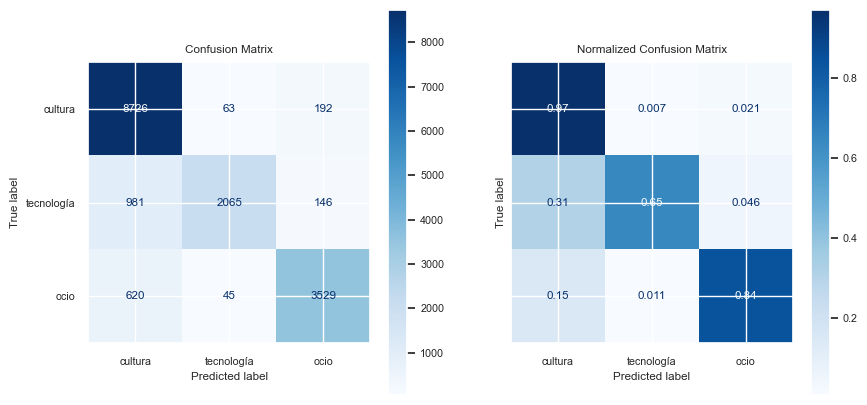

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('standardization',
                                                          MyStandardizationTransformer(cache=None)),
                                                         ('vectorizer',
                                                          TfidfVectorizer()),
                                                         ('model',
                                                          LogisticRegression(max_iter=300))]),
                              transformer=LabelEncoder())

,NAME,TYPE,ACCURACY,ESTIMATOR
0,LogisticRegression(max_iter=300),ML,0.7138,MyTransformedTargetClassifier(classifier=Pipel...
1,LogisticRegression(max_iter=300),ML,0.7268,MyTransformedTargetClassifier(classifier=Pipel...


In [29]:
results, clf_t = my_grid_search_cv(model=LogisticRegression(max_iter=300), X=features, y=targets, results=results,
                                   vectorizer=TfidfVectorizer, param_grid={})
results

## Naive Bayes

### Multinomial Naive Bayes

The model MultinomialNB() has a degree of accuracy of 74.19%.


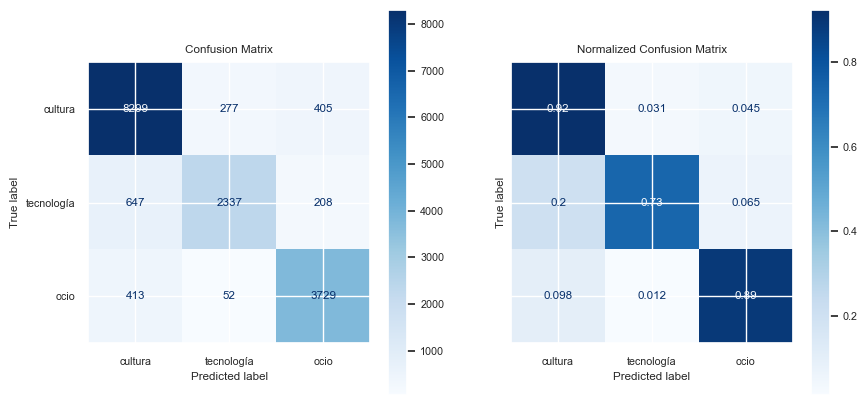

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('standardization',
                                                          MyStandardizationTransformer(cache=None)),
                                                         ('vectorizer',
                                                          CountVectorizer()),
                                                         ('model',
                                                          MultinomialNB())]),
                              transformer=LabelEncoder())

,NAME,TYPE,ACCURACY,ESTIMATOR
0,LogisticRegression(max_iter=300),ML,0.7138,MyTransformedTargetClassifier(classifier=Pipel...
1,LogisticRegression(max_iter=300),ML,0.7268,MyTransformedTargetClassifier(classifier=Pipel...
2,MultinomialNB(),ML,0.7419,MyTransformedTargetClassifier(classifier=Pipel...


In [30]:
results, multinomial_c = my_grid_search_cv(model=MultinomialNB(), X=features, y=targets, results=results,
                                           vectorizer=CountVectorizer, param_grid={})
results

The model MultinomialNB() has a degree of accuracy of 66.0%.


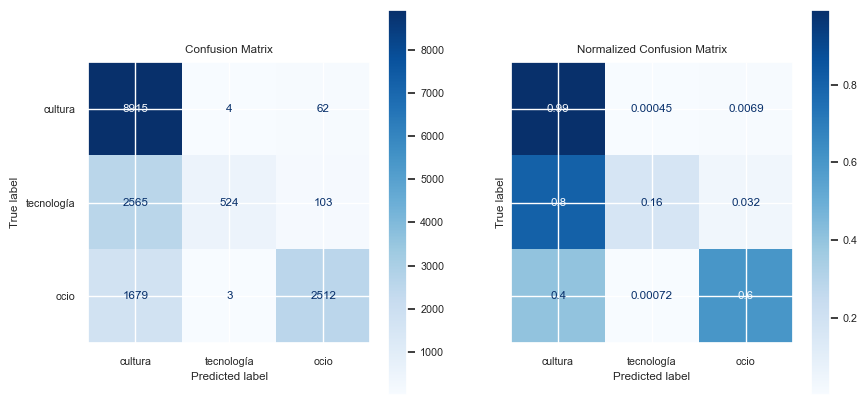

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('standardization',
                                                          MyStandardizationTransformer(cache=None)),
                                                         ('vectorizer',
                                                          TfidfVectorizer()),
                                                         ('model',
                                                          MultinomialNB())]),
                              transformer=LabelEncoder())

,NAME,TYPE,ACCURACY,ESTIMATOR
0,LogisticRegression(max_iter=300),ML,0.7138,MyTransformedTargetClassifier(classifier=Pipel...
1,LogisticRegression(max_iter=300),ML,0.7268,MyTransformedTargetClassifier(classifier=Pipel...
2,MultinomialNB(),ML,0.7419,MyTransformedTargetClassifier(classifier=Pipel...
3,MultinomialNB(),ML,0.6600,MyTransformedTargetClassifier(classifier=Pipel...


In [31]:
results, multinomial_t = my_grid_search_cv(model=MultinomialNB(), X=features, y=targets, results=results,
                                           vectorizer=TfidfVectorizer, param_grid={})
results

### Bernoulli Naive Baye

The model BernoulliNB() has a degree of accuracy of 70.13000000000001%.


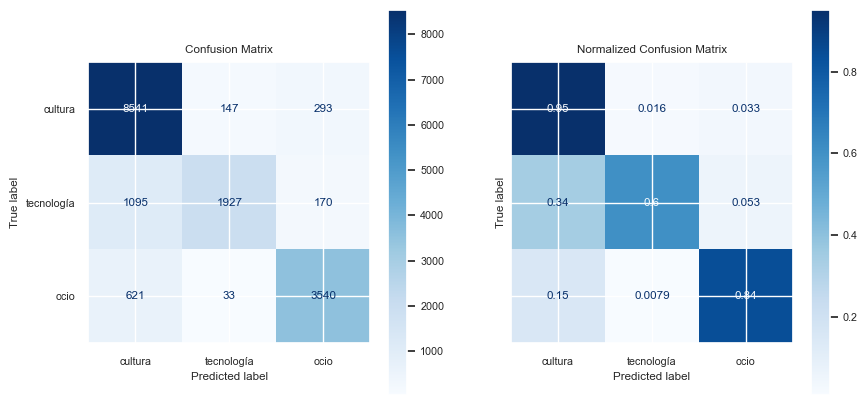

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('standardization',
                                                          MyStandardizationTransformer(cache=None)),
                                                         ('vectorizer',
                                                          CountVectorizer()),
                                                         ('model',
                                                          BernoulliNB())]),
                              transformer=LabelEncoder())

,NAME,TYPE,ACCURACY,ESTIMATOR
0,LogisticRegression(max_iter=300),ML,0.7138,MyTransformedTargetClassifier(classifier=Pipel...
1,LogisticRegression(max_iter=300),ML,0.7268,MyTransformedTargetClassifier(classifier=Pipel...
2,MultinomialNB(),ML,0.7419,MyTransformedTargetClassifier(classifier=Pipel...
3,MultinomialNB(),ML,0.6600,MyTransformedTargetClassifier(classifier=Pipel...
4,BernoulliNB(),ML,0.7013,MyTransformedTargetClassifier(classifier=Pipel...


In [32]:
results, bernoulli_c = my_grid_search_cv(model=BernoulliNB(), X=features, y=targets, results=results,
                                         vectorizer=CountVectorizer, param_grid={})
results

The model BernoulliNB() has a degree of accuracy of 70.13000000000001%.


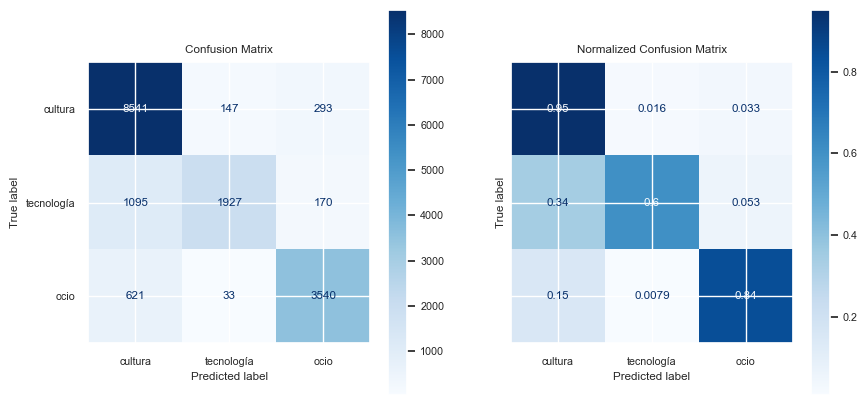

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('standardization',
                                                          MyStandardizationTransformer(cache=None)),
                                                         ('vectorizer',
                                                          TfidfVectorizer()),
                                                         ('model',
                                                          BernoulliNB())]),
                              transformer=LabelEncoder())

,NAME,TYPE,ACCURACY,ESTIMATOR
0,LogisticRegression(max_iter=300),ML,0.7138,MyTransformedTargetClassifier(classifier=Pipel...
1,LogisticRegression(max_iter=300),ML,0.7268,MyTransformedTargetClassifier(classifier=Pipel...
2,MultinomialNB(),ML,0.7419,MyTransformedTargetClassifier(classifier=Pipel...
3,MultinomialNB(),ML,0.6600,MyTransformedTargetClassifier(classifier=Pipel...
4,BernoulliNB(),ML,0.7013,MyTransformedTargetClassifier(classifier=Pipel...
5,BernoulliNB(),ML,0.7013,MyTransformedTargetClassifier(classifier=Pipel...


In [33]:
results, bernoulli_t = my_grid_search_cv(model=BernoulliNB(), X=features, y=targets, results=results,
                                         vectorizer=TfidfVectorizer, param_grid={})
results

# Deep Learning

Cuda version.

In [34]:
print(f'Tensorflow version: {tf.__version__}')
print(f"Cuda version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")

Tensorflow version: 2.6.0
Cuda version: 64_113
Cudnn version: 64_8


**Enable GPU**

- The environment must be created with a version of Python compatible with the operation of Tensorflow and its use of the GPU (https://www.tensorflow.org/install/pip#virtual-environment-install).
- Before installing tensorflow-gpu you must install CUDA Toolkit and cuDNN from official NVIDIA site.
- Anaconda must be restarted after installing tensorflow-gpu.

In [35]:
# !conda install -y tensorflow-gpu keras-gpu

if len(tf.config.list_physical_devices('GPU')) == 0:
    raise SystemExit('Restart Anaconda to activate the GPU.')
else:
    print('GPU activated.')

GPU activated.


Available hardware.

In [36]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available hardware details.

In [37]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17526754577285520189,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2236245607
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10664081190073916319
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

## Tensorboard

In [38]:
# !rm -rf logs/

In [39]:
# %load_ext tensorboard
# %tensorboard --logdir logs

# # if error: eliminar .tensorboard-info en C:\Users\%username%\AppData\Local\Temp

In [40]:
tensorboard = TensorBoard(os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S")), histogram_freq=1,
                          write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)

## Vectorizer

Se debe seleccionar `Tokenizer`[1], `TextVectorization`[2] o `spacy`[3].

[1] y [2]: Se genera una capa de incrustación.

[3]: No es necesario generar una capa de incrustación.

Se puede restringir la cantidad de muestras, el número de palabras del diccionario y el máximo de palabras tomadas por cada observación.

In [41]:
# cantidad de muestras
# None: all
print('Total de muestras:', len(standardized_data))
max_samples = None

# número de palabras del diccionario
# None: all
max_tokens = None

# máximo de palabras tomadas por cada observación
# max_len: all
max_len = max([len(sentence.split(sep=' ')) for sentence in standardized_data])
print('Máxima cantidad de palabras por muestras:', max_len)
max_len = max_len

Total de muestras: 16367
Máxima cantidad de palabras por muestras: 54


In [42]:
if max_samples != None:
    print('Before:', standardized_data.shape, targets.shape)

    li = range(0, len(standardized_data)-1)
    i_rand = random.sample(li, max_samples)

    # Se convierte a series para ejecutar el iloc a partir de un listado de indexs.
    standardized_data = pd.Series(data=standardized_data)
    targets = pd.Series(data=targets)

    standardized_data = standardized_data.iloc[i_rand].values
    targets = targets.iloc[i_rand].values

    print('After:', standardized_data.shape, targets.shape)

    del i_rand

### Tokenizer

Se utiliza `Tokenizer` para `normalizar` los datos y que puedan ser utilizado en `Long Short Term Memory Networks (LSTMs)`.

Tokenizer elimina por defecto los signos de puntuación y convierte las mayúsculas en minúsculas.

Para el idioma `Ingles`, son mejores los siguientes parametros:
- filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n'
- lower = False

In [43]:
class MyTokenizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.Tokenizer = Tokenizer(num_words=max_tokens)
        self.Tokenizer.fit_on_texts(X)

        return self

    def transform(self, X, y=None):
        # Transformando cada texto en una secuencia de números enteros.
        vector = self.Tokenizer.texts_to_sequences(X)

        # Rellenando con 0 los valores finales de cada secuencia.
        vector = pad_sequences(sequences=vector, maxlen=max_len, padding='post',
                               truncating='post', value=0.0)

        return vector


vectorizer = MyTokenizer()
vector = vectorizer.fit_transform(standardized_data)

display(vector.shape)

(16367, 54)

Vocabulary.

In [44]:
vocabulary = vectorizer.Tokenizer.word_index
list(vocabulary.items())[:10]

[('año', 1),
 ('mundo', 2),
 ('historia', 3),
 ('español', 4),
 ('tiempo', 5),
 ('forma', 6),
 ('sistema', 7),
 ('españa', 8),
 ('encontrar', 9),
 ('vida', 10)]

Obtener `corpus` a partir de los vectores generados.

In [45]:
display('original:')
display(standardized_data[0])

display('generado:')
display(vectorizer.Tokenizer.sequences_to_texts([vector[0]])[0])

'original:'

'parecer mentira emisión dióxido carbono nitrógeno atmosférico actuar fertilizante tierra verde año acabar ecosistema terrestre saturar encaminar época calentamiento principal conclusión estudio internacional publicado nature ecology evolution trabajo avisar tierra pasar época fertilización calentamiento'

'generado:'

'parecer mentira emisión dióxido carbono nitrógeno atmosférico actuar fertilizante tierra verde año acabar ecosistema terrestre saturar encaminar época calentamiento principal conclusión estudio internacional publicado nature ecology evolution trabajo avisar tierra pasar época fertilización calentamiento'

In [46]:
del vectorizer, vector, vocabulary

### TextVectorization

In [47]:
vectorizer = TextVectorization(max_tokens=max_tokens,
                               output_sequence_length=max_len)

# Build vocabulary
vectorizer.adapt(standardized_data)

# Transform
vector = vectorizer(standardized_data).numpy()

display(vector.shape)

(16367, 54)

Vocabulary.

Se debe actualizar a un diccionario para obtener la misma estructura de datos que `Tokenizer`.

In [48]:
vocabulary = [(word, i) for i, word in enumerate(vectorizer.get_vocabulary())]
vocabulary[:10]

[('', 0),
 ('[UNK]', 1),
 ('año', 2),
 ('mundo', 3),
 ('historia', 4),
 ('español', 5),
 ('tiempo', 6),
 ('forma', 7),
 ('sistema', 8),
 ('españa', 9)]

In [49]:
del vectorizer, vector, vocabulary

### Spacy

In [50]:
class MySpacyVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, cache, indexs=None):
        self.cache = cache
        self.indexs = indexs

    def fit(self, X, y=None, **kwargs):
        self.indexs = kwargs['indexs'] if kwargs != {} else None
        return self

    def transform(self, X, y=None):
        if self.cache is not None and self.indexs is not None:
            return self.cache[self.indexs]

        n = len(X)
        nlp_len = len(nlp(text='a').vector)
        # Se puede inicilizar en zeros (la memoria crece poco a poco)
        # Si se inicializa en ones, se reserva toda la memoria inmediatamente, 1.0 ocupa más espacio que 0.0
        vector = np.ones(shape=(n, max_len, nlp_len), dtype=np.float32)

        for i in range(0, n):
            doc = nlp(str(X[i]))

            v = [tok.vector for tok in doc][:max_len]
            v = np.array(object=v, dtype=np.float32)

            # Se rellenan con ceros cuando la cantidad de palabras de la oración sea menor que el máximo.
            pad_vector = np.zeros(shape=(max_len-v.shape[0], nlp_len),
                                  dtype=np.float32)

            vector[i] = np.concatenate((v, pad_vector), axis=0) \
                if v.shape[0] != 0 else pad_vector

            print("\r Items {0} of {1}".format(i, n), end='')

        return vector

In [51]:
try:
    pkl_filename = '_resources/spacy_vectorized_data_0501.pkl'
    vector = pickle.load(open(pkl_filename, 'rb'))
except:
    vectorizer = MySpacyVectorizer(cache=None)
    vector = vectorizer.fit_transform(standardized_data)

    pickle.dump(vector, open(pkl_filename, 'wb'))
    del vectorizer
finally:
    display(vector.shape)
    del vector

(16367, 54, 96)

## Keras

Training and test data are generated.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2,
                                                    shuffle=True)

In [53]:
def build_keras_model(net_type, first_layers):
    with tf.device('/GPU:0'):
        # Clear backend
        backend.clear_session()

        keras_model = Sequential()

        for layer in first_layers:
            keras_model.add(layer)

        if net_type == 'LSTM':
            for i in range(0, 5):
                keras_model.add(layer=LSTM(units=100, dropout=0.2,
                                           return_sequences=True))

            keras_model.add(layer=LSTM(units=100, dropout=0.2,
                                       return_sequences=False))
        elif net_type == 'CNN':
            for i in range(0, 5):
                keras_model.add(layer=Conv1D(filters=100, kernel_size=3,
                                             padding='same', activation='relu'))
                keras_model.add(layer=MaxPooling1D())
                keras_model.add(layer=Dropout(rate=0.2))

        else:
            raise Exception(f'Invalid net_type: {net_type}')

        keras_model.add(layer=Dense(units=3, activation='softmax'))

        keras_model.compile(optimizer=Adam(),                 # optimizer
                            loss='categorical_crossentropy',  # función de pérdida o coste
                            metrics=['accuracy'])             # Metrics to observe the evolution of the model training

        display(keras_model.summary())

        return keras_model

In [54]:
def build_keras_estimator(vectorizer, keras_model):
    standardization = MyStandardizationTransformer(standardized_data)

    pipe = Pipeline(steps=[('standardization', standardization),
                           ('vectorizer', vectorizer),
                           ('model', keras_model)])

    target_transformer = OneHotEncoder(sparse=False)

    keras_estimator = MyTransformedTargetClassifier(classifier=pipe,
                                                    transformer=target_transformer)

    if isinstance(curr_vectorizer, MyTokenizer) or isinstance(curr_vectorizer, MyPassthroughEstimator):
        X_val = standardization.fit_transform(X=X_test)
        X_val = vectorizer.transform(X=X_val)

        y_test_re = np.reshape(y_test.values, (-1, 1))
        y_val = target_transformer.fit_transform(y_test_re)

        keras_estimator.fit(X_train, y_train, model__batch_size=64, model__epochs=10, model__verbose=1,
                            model__shuffle=True, model__callbacks=[],
                            model__validation_data=(X_val, y_val))
    elif isinstance(curr_vectorizer, MySpacyVectorizer):
        X_val = standardization.fit_transform(X=X_test)
        vectorizer.fit(X=X_val, indexs=X_test.index)
        X_val = vectorizer.transform(X=X_val)

        y_test_re = np.reshape(y_test.values, (-1, 1))
        y_val = target_transformer.fit_transform(y_test_re)

        keras_estimator.fit(X_train, y_train, model__batch_size=64, model__epochs=10, model__verbose=1,
                            model__shuffle=True, model__callbacks=[],
                            model__validation_data=(X_val, y_val),
                            vectorizer__indexs=X_train.index)

    return keras_estimator

Listado de los `vectorizer` y `keras_net_type`.

In [55]:
class MyPassthroughEstimator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

In [56]:
@interact(vectorizer_type=['Tokenizer', 'TextVectorization', 'Spacy'],
          keras_net_type=['LSTM', 'CNN'])
def _(vectorizer_type, keras_net_type):
    if vectorizer_type == 'Tokenizer':
        vectorizer = MyTokenizer()
        vector = vectorizer.fit_transform(standardized_data)
        vocabulary = vectorizer.Tokenizer.word_index

        first_layers = [Embedding(input_dim=len(vocabulary) + 1, output_dim=128,
                                  input_length=vector.shape[1])]
    elif vectorizer_type == 'TextVectorization':
        vectorize_layer = TextVectorization(max_tokens=max_tokens,
                                            output_sequence_length=max_len)
        vectorize_layer.adapt(standardized_data)
        vocabulary = vectorize_layer.get_vocabulary()

        first_layers = [Input(shape=(1,), dtype=tf.string)]
        first_layers.append(vectorize_layer)
        first_layers.append(Embedding(input_dim=len(vocabulary) + 1,
                                      output_dim=128))

        vectorizer = MyPassthroughEstimator()
    elif vectorizer_type == 'Spacy':
        pkl_filename = '_resources/spacy_vectorized_data_0501.pkl'
        vector = pickle.load(open(pkl_filename, 'rb'))

        first_layers = [Input(shape=vector.shape[1:])]

        vectorizer = MySpacyVectorizer(cache=vector)

    keras_model = build_keras_model(keras_net_type, first_layers)

    global curr_vectorizer_type, curr_keras_net_type
    curr_vectorizer_type, curr_keras_net_type = vectorizer_type, keras_net_type

    global curr_vectorizer, curr_keras_model
    curr_vectorizer, curr_keras_model = vectorizer, keras_model

interactive(children=(Dropdown(description='vectorizer_type', options=('Tokenizer', 'TextVectorization', 'Spac…

Ejecutar las líneas restantes siempre que se seleccionen nuevos valores de `vectorizer` y `keras_net_type`.

In [57]:
keras_estimator = build_keras_estimator(curr_vectorizer, curr_keras_model)

Epoch 1/10
205/205 [==============================] - 21s 54ms/step - loss: 0.8440 - accuracy: 0.6342 - val_loss: 1.1108 - val_accuracy: 0.5211
Epoch 2/10
205/205 [==============================] - 9s 45ms/step - loss: 0.5562 - accuracy: 0.7822 - val_loss: 1.3571 - val_accuracy: 0.4597
Epoch 3/10
205/205 [==============================] - 9s 45ms/step - loss: 0.3349 - accuracy: 0.8873 - val_loss: 1.5258 - val_accuracy: 0.4707
Epoch 4/10
205/205 [==============================] - 9s 45ms/step - loss: 0.2072 - accuracy: 0.9389 - val_loss: 1.9655 - val_accuracy: 0.4566
Epoch 5/10
205/205 [==============================] - 9s 43ms/step - loss: 0.1553 - accuracy: 0.9586 - val_loss: 1.7576 - val_accuracy: 0.4713
Epoch 6/10
205/205 [==============================] - 9s 44ms/step - loss: 0.1181 - accuracy: 0.9701 - val_loss: 1.6106 - val_accuracy: 0.5000
Epoch 7/10
205/205 [==============================] - 9s 45ms/step - loss: 0.0953 - accuracy: 0.9772 - val_loss: 2.0877 - val_accuracy: 0.490

Analyzing the training and evaluation data.

In [58]:
keras_model = keras_estimator.classifier['model']

historial_train = keras_model.history
hist = pd.DataFrame(historial_train.history)
hist['epoch'] = historial_train.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.118103,0.970060,1.610628,0.500000,5
6,0.095312,0.977240,2.087730,0.490226,6
7,0.077717,0.982662,2.178563,0.448687,7
8,0.074671,0.983350,2.230853,0.470373,8
9,0.071255,0.983503,2.371193,0.466097,9


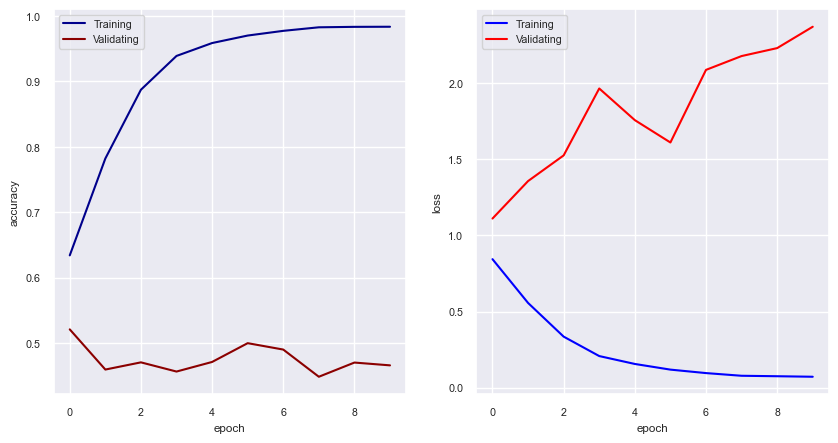

In [59]:
def plot_metrics(train):
    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.plot(train.history['accuracy'], color='darkblue', label='Training')
    ax1.plot(train.history['val_accuracy'],
             color='darkred', label='Validating')
    ax1.legend()

    ax1 = plt.subplot(1, 2, 2)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(train.history['loss'], color='blue', label='Training')
    ax1.plot(train.history['val_loss'], color='red', label='Validating')
    ax1.legend()


plot_metrics(historial_train)

Model evaluation.

In [60]:
if isinstance(curr_vectorizer, MySpacyVectorizer):
    keras_estimator.classifier['vectorizer'].set_params(
        **{'indexs': X_train.index})

acc_train = accuracy_score(y_train, keras_estimator.predict(X=X_train))

if isinstance(curr_vectorizer, MySpacyVectorizer):
    keras_estimator.classifier['vectorizer'].set_params(
        **{'indexs': X_test.index})

acc_test = accuracy_score(y_test, keras_estimator.predict(X=X_test))

acc_train, acc_test = round(acc_train, 4), round(acc_test, 4)

print(f'\nAccuracy Train: {acc_train}')
print(f'Accuracy Test: {acc_test}')


Accuracy Train: 0.9899
Accuracy Test: 0.6915


Se elimina la cache de `standardization` antes de exportar el modelo.

In [61]:
keras_estimator.classifier['standardization'].set_params(**{'cache': None})

if isinstance(curr_vectorizer, MySpacyVectorizer):
    keras_estimator.classifier['vectorizer'].set_params(**{'cache': None,
                                                           'indexs': None})

In [62]:
keras_estimator

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('standardization',
                                                          MyStandardizationTransformer(cache=None)),
                                                         ('vectorizer',
                                                          MyTokenizer()),
                                                         ('model',
                                                          <keras.engine.sequential.Sequential object at 0x0000021427832460>)]),
                              transformer=OneHotEncoder(sparse=False))

In [63]:
new_df = pd.DataFrame(data={'NAME': [f'Keras ({curr_keras_net_type} - {curr_vectorizer_type})'],
                            'TYPE': 'DL', 'ACCURACY': [acc_test],
                            'ESTIMATOR': [keras_estimator]})
results = pd.concat([results, new_df], ignore_index=True)
results

,NAME,TYPE,ACCURACY,ESTIMATOR
0,LogisticRegression(max_iter=300),ML,0.7138,MyTransformedTargetClassifier(classifier=Pipel...
1,LogisticRegression(max_iter=300),ML,0.7268,MyTransformedTargetClassifier(classifier=Pipel...
2,MultinomialNB(),ML,0.7419,MyTransformedTargetClassifier(classifier=Pipel...
3,MultinomialNB(),ML,0.6600,MyTransformedTargetClassifier(classifier=Pipel...
4,BernoulliNB(),ML,0.7013,MyTransformedTargetClassifier(classifier=Pipel...
5,BernoulliNB(),ML,0.7013,MyTransformedTargetClassifier(classifier=Pipel...
6,Keras (LSTM - Tokenizer),DL,0.6915,MyTransformedTargetClassifier(classifier=Pipel...


# Resume

In [64]:
results_sort = results.sort_values(by=['ACCURACY'], ascending=[False])
results_sort

,NAME,TYPE,ACCURACY,ESTIMATOR
2,MultinomialNB(),ML,0.7419,MyTransformedTargetClassifier(classifier=Pipel...
1,LogisticRegression(max_iter=300),ML,0.7268,MyTransformedTargetClassifier(classifier=Pipel...
0,LogisticRegression(max_iter=300),ML,0.7138,MyTransformedTargetClassifier(classifier=Pipel...
4,BernoulliNB(),ML,0.7013,MyTransformedTargetClassifier(classifier=Pipel...
5,BernoulliNB(),ML,0.7013,MyTransformedTargetClassifier(classifier=Pipel...
6,Keras (LSTM - Tokenizer),DL,0.6915,MyTransformedTargetClassifier(classifier=Pipel...
3,MultinomialNB(),ML,0.6600,MyTransformedTargetClassifier(classifier=Pipel...


<AxesSubplot: ylabel='NAME'>

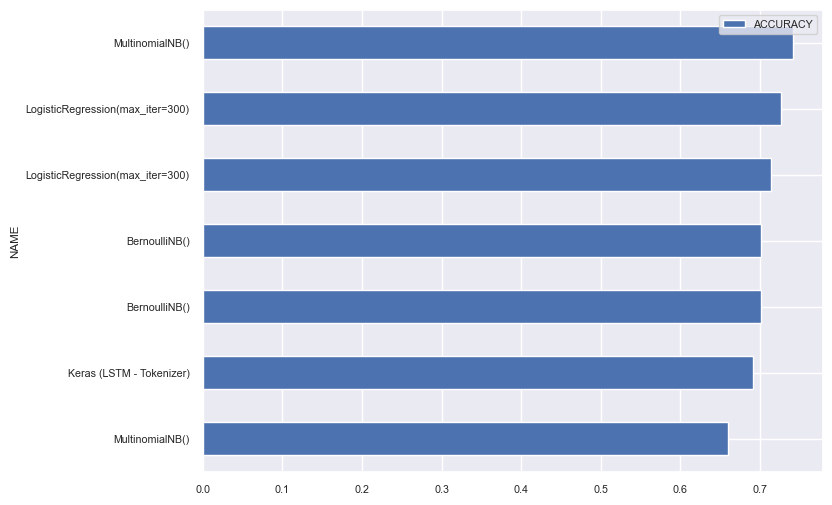

In [65]:
plt.rc('figure', figsize=(8, 6))
results_sort[::-1].set_index('NAME').plot.barh(rot=0)

In [66]:
print(
    f'Best tentative algorithm "{results_sort.iloc[0].NAME}" with ACCURACY={results_sort.iloc[0].ACCURACY}.')

Best tentative algorithm "MultinomialNB()" with ACCURACY=0.7419.


In [67]:
best_sklearn_model = results_sort[results_sort.TYPE == 'ML'].iloc[0].ESTIMATOR
best_keras_model = results_sort[results_sort.TYPE == 'DL'].iloc[0].ESTIMATOR

## Export

Save to file.

In [68]:
sklearn_model_filename = '_resources/0501_sklearn_model.pkl'
keras_model_folder = '_resources/0501_keras_model'

pickle.dump(best_sklearn_model, open(sklearn_model_filename, 'wb'))

if isinstance(curr_vectorizer, MyPassthroughEstimator):
    print('Error...')

    # vectorizer_type == 'TextVectorization' => error
    # NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5,
    #     use `save_format='tf'` instead. Got a model or layer TextVectorization with weights
    #     [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x0000026E952E00A0>]
else:
    best_keras_model.save(keras_model_folder)

Load from file.

In [69]:
sklearn_model_loaded = pickle.load(open(sklearn_model_filename, 'rb'))

if isinstance(curr_vectorizer, MyPassthroughEstimator):
    print('Error...')
else:
    keras_model_loaded = MyTransformedTargetClassifier.load(keras_model_folder)

display(sklearn_model_loaded, keras_model_loaded)

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('standardization',
                                                          MyStandardizationTransformer(cache=None)),
                                                         ('vectorizer',
                                                          CountVectorizer()),
                                                         ('model',
                                                          MultinomialNB())]),
                              transformer=LabelEncoder())

MyTransformedTargetClassifier(classifier=Pipeline(steps=[('standardization',
                                                          MyStandardizationTransformer(cache=None)),
                                                         ('vectorizer',
                                                          MyTokenizer()),
                                                         ('model',
                                                          <keras.engine.sequential.Sequential object at 0x00000215DF514970>)]),
                              transformer=OneHotEncoder(sparse=False))

## Predict

In [70]:
_X = df.sample(20)

pred_df = pd.DataFrame(data={'REAL': _X.categoria,
                             'SKLEARN_PRED': sklearn_model_loaded.predict(X=_X.descripcion),
                             'KERAS_PRED': keras_model_loaded.predict(X=_X.descripcion)})

pred_df

Transforming data: 20 of 20

,REAL,SKLEARN_PRED,KERAS_PRED
14138,cultura,cultura,cultura
11844,ocio,ocio,ocio
15954,cultura,cultura,cultura
14795,cultura,cultura,cultura
5958,ocio,ocio,ocio
8606,cultura,cultura,cultura
8249,cultura,cultura,tecnología
543,cultura,cultura,cultura
15513,cultura,cultura,cultura
9707,tecnología,tecnología,tecnología
